## Chiptune Generation Project Sandbox

Notebook for trying out some code in an interactive, sandbox-like environment.

In [1]:
from modules import mcc_waves, mcc_parser, mcc_builder

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

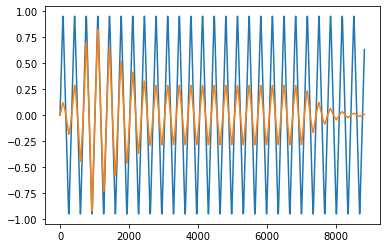

In [2]:
tri_wave = mcc_waves.generate_triangle(48, 4, dur=.2)
envl = mcc_waves.adsr_envelope(.2, [0.1,0.2,0.5])

enveloped_tri_wave = tri_wave * envl

plt.plot(tri_wave)
plt.plot(enveloped_tri_wave )
plt.show()

In [3]:
mid = mcc_parser.open_midi("data/castlevania.mid")

tracks = mcc_parser.extract_midi_tracks(mid.tracks)
track_waves = mcc_waves.create_all_track_waves(tracks, envl=True)
result = mcc_builder.combine_tracks(track_waves)